In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.decomposition import PCA

2024-10-28 15:20:43.876248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 15:20:43.888682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 15:20:43.892375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 15:20:43.901479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 15:20:44.500774: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1730089245.348084    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089245.373508    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089245.376006    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1730089245.404333    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089245.406407    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089245.408304    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089245.505274    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")
# data = pd.read_csv("data/csv/still_with_receiver/still_with_receiver.csv")

data.head()

,timestamps,csi_len,channel,err_info,noise_floor,rate,bandWidth,num_tones,nr,nc,...,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster
0,3689776957,280,2437,0,0,135,0,56,2,1,...,1,0.003257,0.735746,0.704058,0.912444,0,5,3,0.0,1.0
1,3689776957,280,2437,0,0,135,0,56,2,1,...,2,-0.038335,0.813530,0.681169,0.885140,0,5,3,0.0,1.0
2,3689776957,280,2437,0,0,135,0,56,2,1,...,3,-0.053136,1.063410,0.656483,0.853598,0,5,3,0.0,1.0
3,3689776957,280,2437,0,0,135,0,56,2,1,...,5,-0.105276,0.884010,0.632759,0.841939,0,5,3,0.0,1.0
4,3689776957,280,2437,0,0,135,0,56,2,1,...,6,-0.197311,0.933567,0.602048,0.820009,0,5,3,0.0,1.0


In [7]:
# data.drop('with_receiver', axis=1, inplace=True)
# data.drop('nc', axis=1, inplace=True)
# data.drop('ant1_phase', axis=1, inplace=True)
# data.drop('ant2_phase', axis=1, inplace=True)

In [8]:
# data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
# data.drop('rssi', axis=1, inplace=True)
# data.drop('rssi1', axis=1, inplace=True)
# data.drop('rssi2', axis=1, inplace=True)
# data.drop('rssi3', axis=1, inplace=True)
# data.head()
amplitudes_subcarriers = data[['ant1_amplitude', 'ant2_amplitude', 'subcarriers', "rssi", "rssi1", "rssi2"]]
data.drop(columns=["timestamps", 'ant1_amplitude', 'ant2_amplitude', 'subcarriers'], axis=1, inplace=True)

In [9]:
# features_scaled = ["ant1_phase", "ant2_phase", "rssi", "rssi1", "rssi2"]

In [10]:
features_scaled = ["ant1_phase", "ant2_phase"]#, "rssi", "rssi1", "rssi2"]
features = data.columns
# X = data.drop(columns=['coord1', 'coord2', 'ant1_amplitude', 'ant2_amplitude'])
X = data.drop(columns=['coord1', 'coord2'])
y = data[['coord1', 'coord2']]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = X

# Separate the columns that need to be scaled
columns_to_scale = [col for col in X.columns if col not in features_scaled]

# Initialize the scaler
scaler = StandardScaler()

# Apply the scaler to the columns that need to be scaled
X_scaled_part = scaler.fit_transform(X[columns_to_scale])

# Create a DataFrame for the scaled part, with the correct column names
X_scaled_df = pd.DataFrame(X_scaled_part, columns=columns_to_scale)

# Combine the scaled columns with the unscaled columns
X_scaled = pd.concat([X_scaled_df, X[features_scaled]], axis=1)

# Reorder columns to match the original DataFrame's structure (optional)
X_scaled = X_scaled[X.columns]

X_scaled.head()

,csi_len,channel,err_info,noise_floor,rate,bandWidth,num_tones,nr,nc,rssi,rssi1,rssi2,rssi3,payload_length,block_length,ant1_phase,ant2_phase,with_receiver,ant1_amplitude_cluster,ant2_amplitude_cluster
0,-2.395136,0.002533,-0.009847,0.0,-1.615045,0.0,0.0,0.0,-2.395136,-2.405589,-2.413055,-2.404063,0.0,0.767275,-0.798548,0.704058,0.912444,0.0,-0.69164,-0.255681
1,-2.395136,0.002533,-0.009847,0.0,-1.615045,0.0,0.0,0.0,-2.395136,-2.405589,-2.413055,-2.404063,0.0,0.767275,-0.798548,0.681169,0.885140,0.0,-0.69164,-0.255681
2,-2.395136,0.002533,-0.009847,0.0,-1.615045,0.0,0.0,0.0,-2.395136,-2.405589,-2.413055,-2.404063,0.0,0.767275,-0.798548,0.656483,0.853598,0.0,-0.69164,-0.255681
3,-2.395136,0.002533,-0.009847,0.0,-1.615045,0.0,0.0,0.0,-2.395136,-2.405589,-2.413055,-2.404063,0.0,0.767275,-0.798548,0.632759,0.841939,0.0,-0.69164,-0.255681
4,-2.395136,0.002533,-0.009847,0.0,-1.615045,0.0,0.0,0.0,-2.395136,-2.405589,-2.413055,-2.404063,0.0,0.767275,-0.798548,0.602048,0.820009,0.0,-0.69164,-0.255681


In [11]:
for i in range(1, X.shape[0]):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    # print(f'Explained variance by each component: {explained_variance}')
    print(f"PCA with {i} components, sum is {sum(explained_variance)}.")
    
    if (sum(explained_variance) >= 0.85):
        break

PCA with 1 components, sum is 0.3473368246768142.
PCA with 2 components, sum is 0.5289660996570458.
PCA with 3 components, sum is 0.6767420550530735.
PCA with 4 components, sum is 0.7669404746413738.
PCA with 5 components, sum is 0.8228844655710462.
PCA with 6 components, sum is 0.878768144261364.


In [12]:
X = pd.DataFrame(X_pca)
# X = pd.concat([amplitudes.reset_index(drop=True), X], axis=1)
X.head()

,0,1,2,3,4,5
0,-5.598585,1.134140,-0.152097,1.247735,-0.209468,-0.054756
1,-5.598535,1.098648,-0.148985,1.247626,-0.209474,-0.054737
2,-5.598475,1.058888,-0.144148,1.247513,-0.209479,-0.054715
3,-5.598465,1.033870,-0.152686,1.247362,-0.209496,-0.054702
4,-5.598434,0.996651,-0.158905,1.247183,-0.209514,-0.054682


# Model

In [13]:
model_type = "dnn"

In [14]:
# X = data.drop(columns=['coord1', 'coord2']) 
# y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [15]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [16]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [17]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [18]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5235678, 6)
Validation set shape: (1745226, 6)
Test set shape: (1745226, 6)


In [19]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1730089266.012391    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089266.014986    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730089266.017309    7570 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,583,106 (6.04 MB)

 Trainable params: 1,583,106 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def euclidean_distance_loss(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1))

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='./models/checkpoint/model_checkpoint_{epoch:02d}_{val_loss:.2f}.keras',     # Path where the model will be saved
    monitor='val_loss',                 # Monitor the validation loss for improvements
    save_best_only=True,                # Only save the model if it's the best one seen so far
    save_weights_only=False,            # Save the entire model (set to True to save only weights)
    mode='min',                         # In case of loss, use 'min' (use 'max' for accuracy)
    verbose=1                           # Print a message when saving the model
)

# model = load_model('./models/checkpoint/model_checkpoint_42_0.59.keras')

model.compile(optimizer='adam', 
              loss=euclidean_distance_loss,  # Custom Euclidean distance loss
              metrics=['mae'])

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=15, 
                        batch_size=128, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), checkpoint])


Epoch 1/15


I0000 00:00:1730089267.932311    7752 service.cc:146] XLA service 0x770180004fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730089267.932328    7752 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-10-28 15:21:07.953151: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 15:21:08.068769: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-28 15:21:08.739473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 132 bytes spill stores, 132 bytes spill loads

2024-10-28 15:21:09.105249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fu

   98/40904 ━━━━━━━━━━━━━━━━━━━━ 1:03 2ms/step - loss: 2.8255 - mae: 1.8240 

I0000 00:00:1730089272.292158    7752 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40892/40904 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0056 - mae: 1.2829

2024-10-28 15:22:12.024932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 20 bytes spill stores, 20 bytes spill loads

2024-10-28 15:22:12.064724: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 12 bytes spill stores, 12 bytes spill loads

2024-10-28 15:22:12.081800: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 16 bytes spill stores, 16 bytes spill loads

2024-10-28 15:22:12.179205: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 200 bytes spill stores, 200 bytes spill loads

2024-10-28 15:22:12.887142: I external/local_xla/xla/stream_ex

40904/40904 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0055 - mae: 1.2828

2024-10-28 15:22:25.528794: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 20 bytes spill stores, 20 bytes spill loads

2024-10-28 15:22:25.725022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 200 bytes spill stores, 200 bytes spill loads

2024-10-28 15:22:25.920096: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 344 bytes spill stores, 252 bytes spill loads

2024-10-28 15:22:26.023306: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 12 bytes spill stores, 12 bytes spill loads

2024-10-28 15:22:26.357941: I external/local_xla/xla/stream_exec


Epoch 1: val_loss improved from inf to 1.50588, saving model to ./models/checkpoint/model_checkpoint_01_1.51.keras
40904/40904 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 2.0055 - mae: 1.2828 - val_loss: 1.5059 - val_mae: 0.9603
Epoch 2/15
40877/40904 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4549 - mae: 0.9274
Epoch 2: val_loss improved from 1.50588 to 1.34803, saving model to ./models/checkpoint/model_checkpoint_02_1.35.keras
40904/40904 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - loss: 1.4549 - mae: 0.9274 - val_loss: 1.3480 - val_mae: 0.8589
Epoch 3/15
40886/40904 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3318 - mae: 0.8482
Epoch 3: val_loss improved from 1.34803 to 1.27139, saving model to ./models/checkpoint/model_checkpoint_03_1.27.keras
40904/40904 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - loss: 1.3318 - mae: 0.8482 - val_loss: 1.2714 - val_mae: 0.8098
Epoch 4/15
40900/40904 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2682 - mae: 0.8072
Epoch 4: val_loss improved from 1.27139 to 1.23498, sav

In [22]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

2024-10-28 15:37:55.104582: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 132 bytes spill stores, 132 bytes spill loads



54536/54539 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 1.0704 - mae: 0.6798

2024-10-28 15:38:28.576304: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 4 bytes spill stores, 4 bytes spill loads

2024-10-28 15:38:28.720028: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 8 bytes spill stores, 8 bytes spill loads



54539/54539 ━━━━━━━━━━━━━━━━━━━━ 35s 608us/step - loss: 1.0704 - mae: 0.6798
Test Loss: 1.071326732635498, Test MAE: 0.6804052591323853


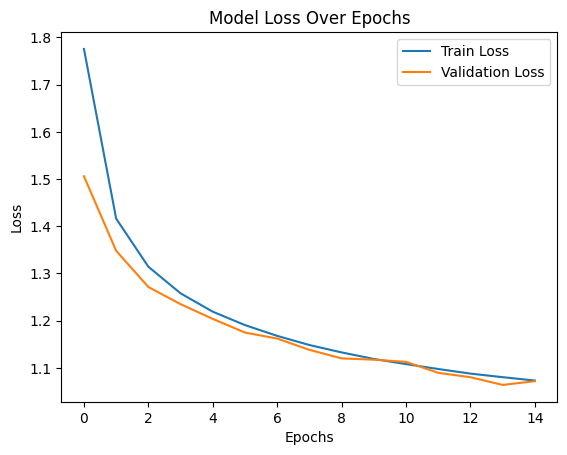

In [23]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
# After training your model
y_pred = model.predict(X_test)

54539/54539 ━━━━━━━━━━━━━━━━━━━━ 32s 578us/step


In [25]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test mae:", results)

Evaluate on test data
13635/13635 ━━━━━━━━━━━━━━━━━━━━ 8s 598us/step - loss: 1.0705 - mae: 0.6798
test loss, test mae: [1.071441650390625, 0.6804777979850769]


In [26]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [27]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.1256
Mean Relative Error for coord2: 0.1214


In [28]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.7694
Spearman's Rank Correlation for coord2: 0.7272


In [29]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [30]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [31]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [32]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.4284


In [33]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.6558
Accuracy within tolerance 0.5: 0.5174
Accuracy within tolerance 0.1: 0.1724


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


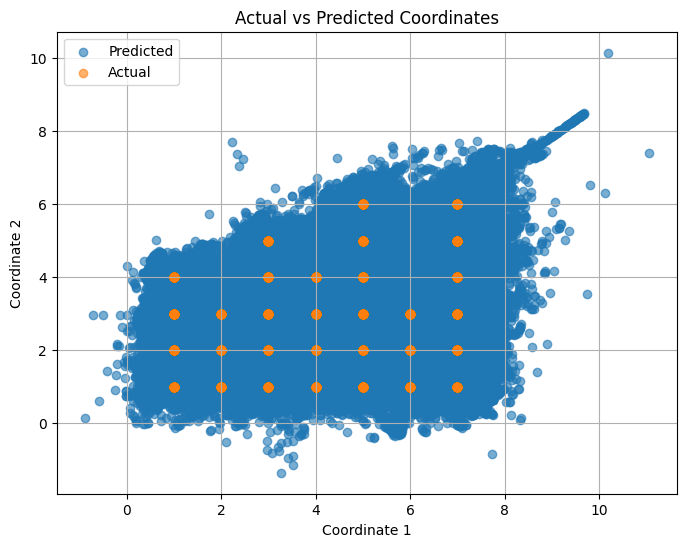

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

MAE for coord1: 0.7538
MAE for coord2: 0.6070
Overall MAE: 0.6804
RMSE for coord1: 1.2829
RMSE for coord2: 1.0011
Overall RMSE: 1.1420
Mean Euclidean Distance Error: 1.0713 units
R-squared for coord1: 0.5902
R-squared for coord2: 0.5529
Median Absolute Error for coord1: 0.2647
Median Absolute Error for coord2: 0.2325


In [36]:
# from sklearn.model_selection import KFold
# import numpy as np

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# mae_scores = []

# for train_index, test_index in kf.split(X):
#     X_train_cv, X_test_cv = X[train_index], X[test_index]
#     y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
#     # Create and train the model
#     model = create_dnn_model(input_shape=(X_train_cv.shape[1],))
#     model.fit(X_train_cv, y_train_cv, epochs=30, batch_size=128, verbose=0)
    
#     # Evaluate the model
#     y_pred_cv = model.predict(X_test_cv)
#     mae_cv = np.mean(np.abs(y_test_cv - y_pred_cv))
#     mae_scores.append(mae_cv)

# print(f"Cross-validated MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

In [37]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")

model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")